<a href="https://colab.research.google.com/github/Vinayak04601/ZS/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install Keras-Preprocessing
!pip install nltk

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

Load Data


In [4]:
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
data.shape

(568454, 10)

Data Cleaning (Handling Missing Values)


In [6]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


Remove rows which are having null values

In [7]:
data.dropna(how='any',inplace=True)

Remove duplicate rows

In [8]:
data.drop_duplicates(inplace=True, subset=['Score','Text'])

"Target" column using Score

In [9]:
## `Score` > 3 : "Positive"
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):

    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [10]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,target
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [11]:
print(data.loc[:, 'target'])

0         Positive
1         Negative
2         Positive
3         Negative
4         Positive
            ...   
568449    Positive
568450    Negative
568451    Positive
568452    Positive
568453    Positive
Name: target, Length: 393656, dtype: object


In [12]:
# target column
data[['Score', 'target']].sample(5)

,Score,target
76802,5,Positive
22151,1,Negative
178050,5,Positive
371935,5,Positive
476133,5,Positive


Handling Class Imbalance as positive is much higher than -ve and neutral.

Target distribution (Before)


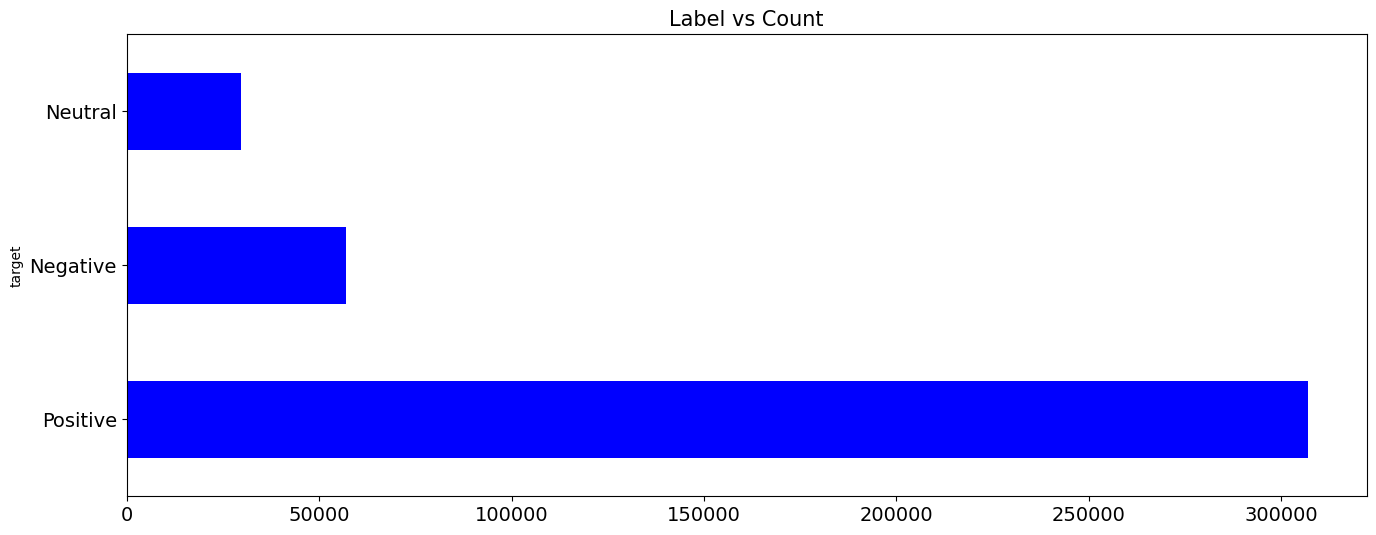

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

Down Sampling some +ve Reviews

In [14]:
neutral = data.loc[data.target=="Neutral"].sample(10000)

positive = data.loc[data.target=="Positive"].sample(10000)

negative = data.loc[data.target=="Negative"].sample(10000)

data = pd.concat([positive, negative, neutral])
data.shape

(30000, 11)

Target distribution (After)

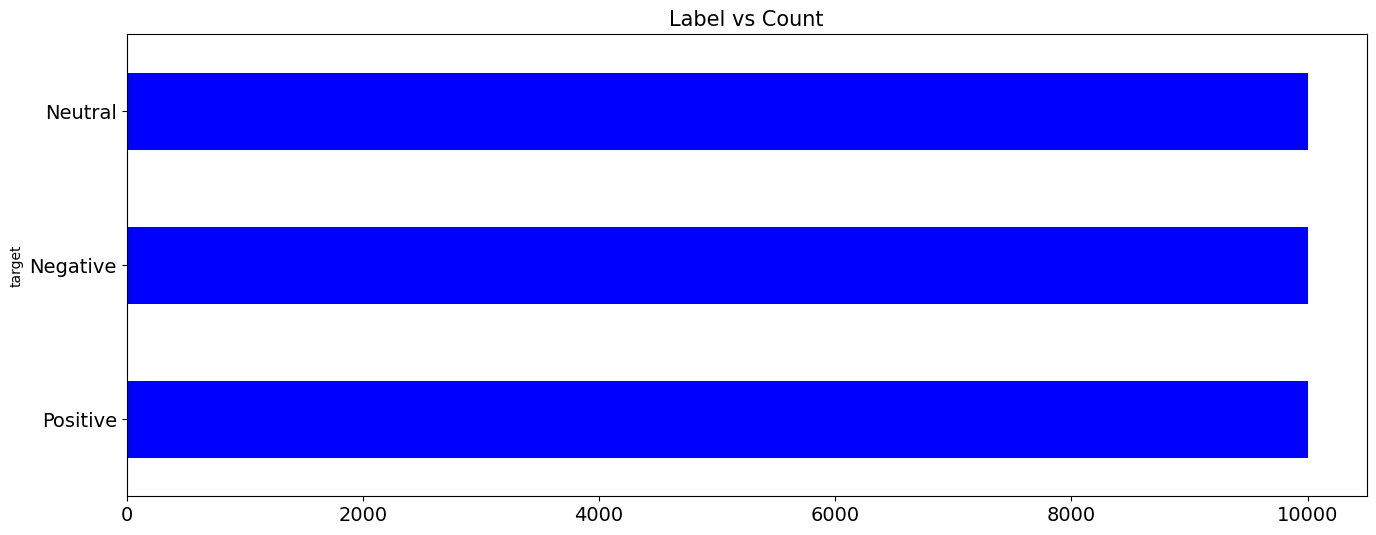

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

Data Pre-processing

In [16]:
from wordcloud import STOPWORDS
import nltk

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Stop words

In [18]:
# stopwords
total_stopwords = set(stopwords.words('english'))
print(total_stopwords)


{'s', 'its', 'doesn', 'was', 'below', 've', 'yours', 'mightn', "wouldn't", 'with', 'myself', "needn't", 'any', 'few', 'these', 'a', 'haven', 'mustn', 'here', 'after', 'yourselves', "doesn't", 'because', 'now', 'we', "you've", 'too', 'ours', 'more', 'out', 'their', 'just', 'above', 'they', 'what', 'further', 'did', 'where', 'over', 'that', 'hasn', 'for', 'some', 'so', 'of', 'in', 'needn', "you're", 'only', 'yourself', 'or', 'he', 'theirs', 'nor', 'my', 'been', 'himself', "didn't", 'd', 'to', "isn't", 'itself', 'weren', 'won', "wasn't", 'each', 'is', 'on', "shouldn't", 'isn', 'again', 'shouldn', 'wouldn', 'those', 'same', "you'd", 'them', 't', 'you', 'against', 'off', 'there', 'into', 'am', 'couldn', 'hadn', 'm', 'by', 'once', 'down', 'all', 'ma', 'having', 'doing', 'o', "should've", "won't", "aren't", 'she', 'had', 'how', "it's", 'were', 'should', 'than', "haven't", 'ourselves', "hadn't", 'i', "don't", 'not', 'no', 'can', 'at', 'does', "couldn't", 'about', 'it', 'y', 'do', 'and', 're', 

Remove unwanted words from reviews
Ex. html tags, punctuation, stop words, etc..

In [19]:
#stemming object
stemmer = PorterStemmer()

HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")

In [20]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)

    # remove digits
    review = review.translate(remove_digits)

    # lower case all letters
    review = review.lower()

    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()

    # remove stop words
    review = [word for word in review.split()
              if word not in total_stopwords]

    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])

    return review

In [21]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


'Not quite a gummi but far superior in taste and freshness.  Anyone who likes the berry lifesavers should try the chewy ones.  Very tasty and extremely fresh.'

In [22]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor)
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'quit gummi far superior tast fresh anyon like berri lifesav tri chewi one tasti extrem fresh'

Train Test Split

Train set : 70% of data
Test set : 30% of data

In [23]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.30, random_state=1, stratify=y)

In [24]:
y.head()

,target
504153,Positive
231118,Positive
295837,Positive
353532,Positive
36807,Positive


In [25]:
X_train.shape, X_test.shape

((21000,), (9000,))

Vectorization
Bag of Words Vectorizer

In [26]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

Test Example of Vecoization

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

# Sample text corpus
corpus = [
    "i aa b c love pizza",
    "Pizza is delicious and  love it",
    "Do you love pizza too?",
    " enjoy pasta more than pizza",
    "Pizza and pasta are both great dishes"
]

# Create CountVectorizer with max_features=10000
vectorizer = CountVectorizer(max_features=10000)

# Fit and transform the corpus
X = vectorizer.fit_transform(corpus)

# Show the count matrix as an array (dense format)
print(X.toarray())

# Display the top 10000 features (in this case, there are fewer than 10000)
print(vectorizer.get_feature_names_out())

[[1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]
 [0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0]
 [0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0]]
['aa' 'and' 'are' 'both' 'delicious' 'dishes' 'do' 'enjoy' 'great' 'is'
 'it' 'love' 'more' 'pasta' 'pizza' 'than' 'too' 'you']


TF-IDF Vectorizer

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

Label Encoding


In [29]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


In [30]:
print(y_train,y_test)

[0 1 0 ... 1 2 0] [1 1 2 ... 2 2 0]


Model Training

In [31]:
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print(model)
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")


Random Forest - BOW

In [32]:
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, classification_report


# Create a Random Forest classifier
rambow = RandomForestClassifier(n_estimators=100, random_state=42)

train_and_eval(model=rambow,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

RandomForestClassifier(random_state=42)
Test accuracy score : 0.6502222222222223



Random Forest - itfidf

In [33]:
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score, classification_report


# Create a Random Forest classifier
ramit = RandomForestClassifier(n_estimators=100, random_state=42)

train_and_eval(model=ramit,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

RandomForestClassifier(random_state=42)
Test accuracy score : 0.6424444444444445


XGBoost - BOW

In [35]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report



# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(bow_X_train, label=y_train)
dtest = xgb.DMatrix(bow_X_test, label=y_test)

xgbowmodel = xgb.XGBClassifier(random_state=42)
train_and_eval(model=xgbowmodel,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Test accuracy score : 0.6494444444444445


XGBoost - itidf

In [36]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report



# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(bow_X_train, label=y_train)
dtest = xgb.DMatrix(bow_X_test, label=y_test)

xgbitmodel = xgb.XGBClassifier(random_state=42)
train_and_eval(model=xgbitmodel,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
Test accuracy score : 0.6562222222222223


In [37]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("xgbit.pkl", "wb") as f:
    pickle.dump(xgbitmodel, f)

In [38]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(xgbitmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [39]:
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [40]:
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!


In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, accuracy_score

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Prepare the dataset for BERT
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=self.max_len, return_tensors='pt')
        encoding = {key: val.squeeze(0) for key, val in encoding.items()}
        encoding['labels'] = torch.tensor(self.labels[idx])
        return encoding

# Convert the dataset
train_dataset = SentimentDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = SentimentDataset(X_test.tolist(), y_test.tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Train the model
model.train()
for epoch in range(3):  # Training for 3 epochs
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
bert_preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        bert_preds.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Classification report for DistilBERT
print("DistilBERT Classification Report:\n", classification_report(true_labels, bert_preds))
bert_accuracy = accuracy_score(true_labels, bert_preds)
print(f"DistilBERT Accuracy: {bert_accuracy}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
